# 数据预处理

## 探索数据集

100000个图像问价存储在“/input/”文件路径中，图像文件的真实标签和详细路径存储在‘train.csv’文件中，文件的前两行是<br>
‘filename,label <br>
train/0.jpg,(0+0)+9=9’。

In [1]:
##获取数据集实际标签 和 文件路径

import csv
import numpy as np

csv_file = "input/train.csv"
reader = csv.reader(open(csv_file))
csv_data = []
for item in reader:
    csv_data.append(item)
csv_data = csv_data[1:]

img_path = ['input/'+label[0] for label in csv_data] # 路径
labels = [label[1] for label in csv_data] # 标签

In [2]:
## 定义常量

#算式中的字符集
chars = '0123456789+-*()=' 
chars_array = np.array(list(chars))

#分类数量
n_class = len(chars)+1
#算式最大长度 = 11
n_seq = 17


In [3]:
# 将数据集随机分为训练集、验证集和测试集
from sklearn.model_selection import train_test_split

img_path_, img_path_test, labels_, labels_test = train_test_split(img_path, labels, 
                                                                test_size=10000, random_state=9999)
img_path_train, img_path_valid, labels_train, labels_valid = train_test_split(img_path_, labels_, 
                                                                test_size=10000, random_state=9999)

print(len(img_path_train),len(img_path_valid),len(img_path_test))

80000 10000 10000


In [6]:
from keras.preprocessing import image  
import cv2
import string

# 将文件路径转换成CNN输入的4维数组（num_samples, rows, columns, channels）
def path_to_tensor(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255 #转换图像像素为灰度值，并进行归一化
    gray = image.img_to_array(gray)
    return np.expand_dims(gray, axis=0)

def paths_to_tensors(paths):
    list_tensors = [path_to_tensor(path) for path in paths]
    return np.vstack(list_tensors)

# 获取真实标签长度
def get_label_length(labels):
    length = np.zeros((len(labels),1))
    for i, label in enumerate(labels):
        length[i] = len(label)
    return length
        
# 获取标签数组
# code，长度为已经定义的最长字符串:n_seq
def get_code(label):
    code = np.zeros(n_seq)
    for i, char in enumerate(label):
        code[i] = chars.find(char)
    return code


In [7]:
# 生成数据集
X_train, X_valid, X_test = [paths_to_tensors(img_path) for img_path in [img_path_train, img_path_valid, img_path_test]]

y_train = np.array([get_code(label) for label in labels_train])
y_valid = np.array([get_code(label) for label in labels_valid])
y_test = np.array([get_code(label) for label in labels_test])

In [110]:
# 查看数据集的维度
print((X_train.shape,X_valid.shape,X_test.shape))
print((y_train.shape,y_valid.shape,y_test.shape))

((80000, 64, 300, 1), (10000, 64, 300, 1), (10000, 64, 300, 1))
((80000, 17), (10000, 17), (10000, 17))


In [113]:
# 获取标签长度
label_length_train = get_label_length(labels_train)
label_length_valid = get_label_length(labels_valid)
label_length_test = get_label_length(labels_test)

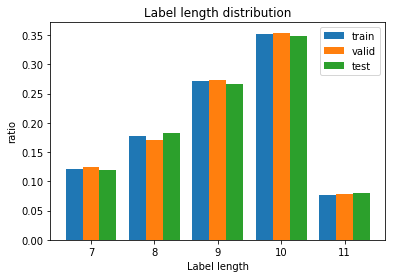

In [114]:
## 查看算式字符长度的分布直方图

import matplotlib.pyplot as plt
%matplotlib inline
#length = get_label_length(labels)
plt.subplot();
plt.hist(x=[label_length_train,label_length_valid,label_length_test],
         bins=[7,8,9,10,11,12],align='left',density=1,);
plt.title('Label length distribution');
plt.legend(['train','valid','test']);
plt.xlabel('Label length');
plt.ylabel('ratio');

## 构建网络

In [11]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation, Permute, TimeDistributed, Lambda, Input

from keras.layers import LSTM, CuDNNLSTM, Bidirectional, CuDNNGRU
from keras.regularizers import L1L2
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
height, width, channel = X_train.shape[1:]
#height, width, channel = [64, 300, 1]

input_tensor = Input(shape=[height, width, channel])
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, 3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=2, padding='same')(x)
    
x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = Conv2D(512, 3, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = MaxPooling2D((1, 2), strides=2, padding='same')(x)
x = Dropout(rate=0.7)(x)

x = Permute((2,1,3))(x)

x = TimeDistributed(Flatten())(x)

x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)

y_pred = Dense(n_class,activation='softmax')(x)

base_model = Model(inputs=input_tensor,outputs = y_pred)

#base_model.summary()

In [26]:
# 解码RNN输出的序列

import re
chars_space = chars + u' '
def decode(pred):
    # 输入base_mode的预测输出
    pred = pred.argmax(axis=2)
    orig_labels = []
    new_labels = []
    for i, code in enumerate(pred):
        orig_labels.append(''.join([chars_space[x] for x in code]))
    for string in orig_labels:
        # 使用正则表达式去除RNN输出序列中多余的重复和空格
        new_labels.append(re.sub(r'\s','',re.sub(r'(.)\1+', r'\1', string)))
                                 
    return [np.array(orig_labels), np.array(new_labels)]
    

In [27]:
from keras.callbacks import *

def evalute_valid(model):
    pred = model.predict(X_valid)
    _, new_labels = decode(pred)
    return (new_labels==labels_valid).mean()*100

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evalute_valid(base_model)
        self.accs.append(acc)
        print('valid acc: %f%%'%acc)

evaluator = Evaluate()

In [28]:
import keras.backend as K
from keras.optimizers import Adadelta, SGD, RMSprop

#  CTC-Loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    #y_pred = y_pred[:, 2:, :] 不屏蔽会报错
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='the_labels', shape=[None], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# 定义优化器
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
ada = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0) # Keras推荐的默认参数，准确率震荡较大
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) # 

# 完整的 CNN + LSTM + CTC 模型 ：model
model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
# 编译model
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 300, 32)  320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 150, 32)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 150, 64)  18496       max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
max_poolin

In [29]:
import os

model_file_path = '/output/model01.hd5'

if os.path.exists(model_file_path):
    pass
    #base_model.load_weights(model_file_path)

In [30]:
checkpointer = ModelCheckpoint(filepath=model_file_path, 
                               verbose=1, monitor='val_loss', save_best_only=True)
esp = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tb = TensorBoard(log_dir='./output', update_freq='epoch')

# 最终模型的输入：
# input_tensor = X_train
# labels = y_train
input_len_to_ctc = np.array(np.ones((len(X_train),1))*base_model.output_shape[1])
label_len_to_ctc = label_length_train

input_len_to_ctc2 = np.array(np.ones((len(X_valid),1))*base_model.output_shape[1])
label_len_to_ctc2 = label_length_valid


fited = model.fit(x=[X_train, y_train, input_len_to_ctc, label_len_to_ctc], 
                  y=np.ones(len(y_train)),
                  validation_data=([X_valid, y_valid, input_len_to_ctc2, label_len_to_ctc2], np.ones(len(y_valid))),
                  batch_size=200, epochs=100, callbacks=[checkpointer, evaluator, esp, tb], verbose=1)

Train on 80000 samples, validate on 10000 samples
Epoch 1/100
80000/80000 [==============================] - 75s 943us/step - loss: 14.1848 - val_loss: 7.4667

Epoch 00001: val_loss improved from inf to 7.46670, saving model to /output/model01.hd5
valid acc: 11.620000%
Epoch 2/100
80000/80000 [==============================] - 74s 923us/step - loss: 2.4517 - val_loss: 1.2006

Epoch 00002: val_loss improved from 7.46670 to 1.20059, saving model to /output/model01.hd5
valid acc: 75.110000%
Epoch 3/100
80000/80000 [==============================] - 74s 924us/step - loss: 0.9899 - val_loss: 0.7811

Epoch 00003: val_loss improved from 1.20059 to 0.78109, saving model to /output/model01.hd5
valid acc: 84.070000%
Epoch 4/100
80000/80000 [==============================] - 74s 924us/step - loss: 0.5704 - val_loss: 0.3679

Epoch 00004: val_loss improved from 0.78109 to 0.36791, saving model to /output/model01.hd5
valid acc: 91.950000%
Epoch 5/100
80000/80000 [==============================] - 74


Epoch 00041: val_loss did not improve from 0.04611
valid acc: 98.600000%
Epoch 42/100
80000/80000 [==============================] - 74s 925us/step - loss: 0.0194 - val_loss: 0.0500

Epoch 00042: val_loss did not improve from 0.04611
valid acc: 98.910000%
Epoch 43/100
80000/80000 [==============================] - 74s 925us/step - loss: 0.0170 - val_loss: 0.0706

Epoch 00043: val_loss did not improve from 0.04611
valid acc: 98.580000%
Epoch 44/100
80000/80000 [==============================] - 74s 926us/step - loss: 0.0148 - val_loss: 0.0510

Epoch 00044: val_loss did not improve from 0.04611
valid acc: 99.040000%
Epoch 45/100
80000/80000 [==============================] - 74s 926us/step - loss: 0.0139 - val_loss: 0.0694

Epoch 00045: val_loss did not improve from 0.04611
valid acc: 98.610000%
Epoch 46/100
80000/80000 [==============================] - 74s 925us/step - loss: 0.0156 - val_loss: 0.0645

Epoch 00046: val_loss did not improve from 0.04611
valid acc: 98.610000%
Epoch 00046

## 测试验证

In [50]:
base_model.load_weights(model_file_path)
pred = base_model.predict(X_test)
sequence, new_labels = decode(pred)
test_acc = (new_labels==labels_test).mean()*100
print('test_acc: %f%%'%test_acc)

test_acc: 99.030000%


In [32]:
model.save('model')

dict_keys(['val_loss', 'loss'])


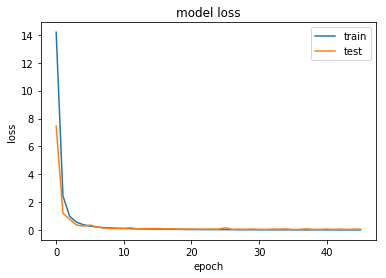

In [34]:
print(fited.history.keys())
# 模型训练过程中的loss
plt.plot(fited.history['loss'])
plt.plot(fited.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

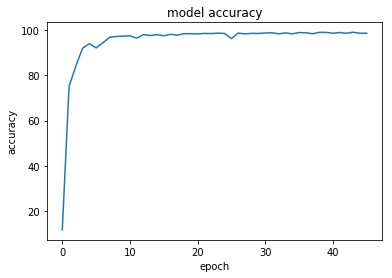

In [35]:
# 模型训练中的准确率
acc = evaluator.accs
plt.plot(acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [54]:
# 查看测试集上模型的输出
print(img_path_test[:5])
print(sequence[:5])
print(new_labels[:5])

['input/train/38162.jpg', 'input/train/95382.jpg', 'input/train/33267.jpg', 'input/train/96645.jpg', 'input/train/97804.jpg']
['4++3-11  ======== 6' '8*((00++9)======7 2' '6-(99-0)) =====-- 3'
 '3*(5-11)  ======1 2' '8++3+22   ======1 3']
['4+3-1=6' '8*(0+9)=72' '6-(9-0)=-3' '3*(5-1)=12' '8+3+2=13']


In [86]:
#查看识别错误的算式
a,b = zip(*((i,j) for i, j in zip(new_labels, labels_test) if i !=j))
c = np.array([a, b])
l1 = np.array([len(i) for i in c[0]])
l2 = np.array([len(i) for i in c[1]])
# 预测长度错误的比例
np.array([l1!=l2]).mean()

0.27835051546391754

In [71]:
#预测错误的部分
c.T

array([['(2*8)+5=27', '(2*8)+5=21'],
       ['(9*17)*1=9', '(9*1)*1=9'],
       ['3-4+1=-0', '3-4*1=-1'],
       ['0*(5-2)=3', '0+(5-2)=3'],
       ['6+2*1=18', '6+2*1=8'],
       ['7*8+1=51', '7*8+1=57'],
       ['1-1*2=-13', '1-7*2=-13'],
       ['0-(8*9)=-12', '0-(8*9)=-72'],
       ['9*3-6=27', '9*3-6=21'],
       ['2+(4*9)=36', '2+(4*9)=38'],
       ['9*2*7=226', '9*2*7=126'],
       ['(14)-4=-7', '(1-4)-4=-7'],
       ['1+8-2=1', '1+8-2=7'],
       ['3+(1+2)=12', '3+(7+2)=12'],
       ['(9*0)*7=0', '(9*0)*2=0'],
       ['4+(1*5)=39', '4+(7*5)=39'],
       ['(3*6)*6=90', '(3*6)*5=90'],
       ['9*(7+2)=27', '9*(1+2)=27'],
       ['4*7*7=96', '4*7*7=196'],
       ['9*8*8=0', '0*8*8=0'],
       ['(0-8)+7=-7', '(0-8)+1=-7'],
       ['1-9-0=8', '1-9-0=-8'],
       ['1-(4-6)=9', '7-(4-6)=9'],
       ['(4+5)*9=88', '(4+5)*9=81'],
       ['(8*1)+9=9', '(0*1)+9=9'],
       ['5-(9+6)=10', '5-(9+6)=-10'],
       ['(3+4)+0=12', '(3*4)+0=12'],
       ['3+(7*6)=9', '3+(1*6)=9'],
       ['4+5+1

In [36]:
# 尝试在其他图像上进行测试

base_model.load_weights('model')
ext_test_file = ['data/test{}.jpg'.format(i) for i in range(5)]
tensor = paths_to_tensors(ext_test_file)
pred = base_model.predict(tensor)
sequence_out, new_labels = decode(pred)

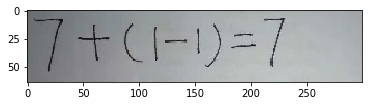

In [46]:
img = cv2.imread(ext_test_file[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

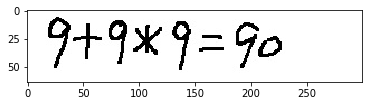

In [47]:
img = cv2.imread(ext_test_file[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [37]:
sequence_out

array(['++10+000  ====111 0', '(777*7)*8  ==== 9 5',
       '((227-2 7-7 === - 6', '((5+1+3))*2 ==1 1 4',
       '1+++1   ========= 2'], dtype='<U19')

In [38]:
new_labels

array(['+10+0=10', '(7*7)*8=95', '(27-27-7=-6', '(5+1+3)*2=114', '1+1=2'],
      dtype='<U13')